### Visualizing and Evaluating Results

In [8]:
import json
import pickle
import numpy as np
from pprint import pprint
from scipy.stats import sem
from statistics import mean, stdev
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
%matplotlib inline
colors = ['royalblue', 'seagreen', 'coral', 'darkorchid', 'gray', 'gold']
hatches = ['//', '||', '--', 'xx', 'oo', r'\\']

# fig_dir = get_full_path("MTL", "Figures")

In [9]:
""" File/dictionary serialization using pickle. """

def save(d, filename):
    """ Serialize a dictionary or object d. """
    with open(f'data/{filename}.pickle', 'wb') as f:
        pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """ Load a previously serialized object from disk. """
    with open(f'data/{filename}.pickle', 'rb') as f:
        return pickle.load(f)
    
""" File/dictionary serialization using JSON. """

def j_save(d, filename):
    """ Serialize a dictionary or list d. """
    with open(f'data/{filename}.json', 'wb') as f:
        json.dump(d, f, indent=2)

def j_load(filename):
    """ Load a previously serialized object from disk. """
    with open(f'data/{filename}.json', 'rb') as f:
        return json.load(f)

In [12]:
### mtl = load("lr_adaptive_cont") # best results for SYNTH dataset

""" CAIDA Baseline """
tasks = ['loss', 'congestion', 'noise']
stl = j_load("stl_results_latest") # best CAIDA STL (includes changepoint, q1, q2)
mtl = load("CAIDA_scores") # CAIDA original (loss, congestion, noise)

# mtl = load("CAIDA_retrain") # adding changepoint task
# tasks = ['loss', 'congestion', 'noise', 'changepoint']

# mtl = load("CAIDA_queries") # changepoint + queries
# tasks = ['loss', 'congestion', 'noise', 'changepoint', 'query2', 'query1'] # swapped order of q1/q2 to make consistent with paper




""" RIPE Atlas Datasets """
""" NOTE: large data files omitted from repository for performance. retrain
    the model on RIPE Atlas data and execute, then change these to the cached
    file names to visualize results. """
# stl = j_load("ripe_stl") # ripe atlas STL results

# RIPE Atlas MTL data can similarly be loaded 

# mtl = load("ripe_mtl") # time: 80.109 seconds, stdev: 1.220s
# tasks = ['loss', 'congestion', 'noise']

# mtl = load("ripe_changept") # 113.3141s, std. dev: 3.998s
# tasks = ['loss', 'congestion', 'noise', 'changepoint']

#### changepoint + queries
# mtl = load("ripe_all_tasks") # time: `170.12106` seconds, stdev: `2.75891`s  
# tasks = ['loss', 'congestion', 'noise', 'changepoint', 'query2', 'query1']

##### ---------------------------

try:
    stl['loss'] = stl.pop('outage')
except:
    pass

""" Single Task Analysis: """
stl_stdev = 0
for t in tasks:
    if 'query' in t:
        continue
    dataset = "Test" # could also use 'Validation'
    scores = [a[0] for a in stl[t][dataset]]
#     print(stl[t][dataset])
    times = [a[1] for a in stl[t][dataset]]
    val_times = [a[1] for a in stl[t]["Validation"]]

    stl[f"{t}_mean_score"] = mean(scores)
    stl[f"{t}_mean_times"] = mean(times) + mean(val_times)
    stl[f"{t}_stdev"] = stdev(scores)
    stl[f"{t}_stderr"] = sem(scores)
    stl[f"{t}_time_stderr"] = sem(times)
        
    print(f"STL '{t}' Mean Score : {round(stl[f'{t}_mean_score'], 5)}; \t\tscore std. dev: {round(stl[t + '_stdev'], 5)}")
    print(f"\tSTL '{t}' avg. time : {round(stl[f'{t}_mean_times'], 5)};\ttimes std. dev: {round(stdev(times), 4)}s")
    print(f"\tSTL '{t}' Std. Error : {round(stl[f'{t}_stderr'], 5)}")
    print(f"\tSTL '{t}' Time Std. Error : {round(stl[f'{t}_time_stderr'], 5)}")
    try:
        stl[t]['time_stdev'] = stdev(times)
        stl_stdev += stdev(times) * stdev(times)
    except:
        stl[t] = {}
        stl[t]['time_stdev'] = stdev(times)
        stl_stdev += stdev(times) * stdev(times)
#     print("variance:", round(stdev(times) * stdev(times), 5))
    print()
print(f"STL time std. dev: {round(math.sqrt(stl_stdev), 5)}")
print('_'*30, '\n')


""" Multi Task Analysis: """
mtl_times = []
mtl_scores = {task : [] for task in tasks}

for i in mtl:
    dataset = 'test' # could also be 'train' or 'valid'
    for j in mtl[i]['Scores'].keys():
        if dataset not in j:
            continue # only want 'test', 'valid', or 'train' datasets
        task = j.split('_')[0] # congestion, noise, loss, or changepoint
        
        try:
            mtl_scores[task].append(mtl[i]['Scores'][j])
        except:
            continue
    
    mtl_times.append(mtl[i]['Time'])
    
for task in tasks:
    mtl[f"{task}_mean_score"] = mean(mtl_scores[task])
    mtl[f"{task}_stdev"] = stdev(mtl_scores[task])
    
    mtl[f"{task}_stderr"] = sem(mtl_scores[task])
#     print(f"{task} stderr: {sem(mtl_scores[task])}")
    
    
    print(f"MTL '{task}' Mean Score:", round(mtl[f"{task}_mean_score"], 5), f"\tstd. dev: {round(mtl[f'{task}_stdev'], 5)}")
print(f"\tMTL avg. time: {round(mean(mtl_times), 5)};\tstd. dev: {round(stdev(mtl_times),3)}s")

mtl['time_stdev'] = stdev(mtl_times)


STL 'loss' Mean Score : 0.99657; 		score std. dev: 0.01814
	STL 'loss' avg. time : 154.46412;	times std. dev: 8.2175s
	STL 'loss' Std. Error : 0.00343
	STL 'loss' Time Std. Error : 1.55297

STL 'congestion' Mean Score : 0.90743; 		score std. dev: 0.20965
	STL 'congestion' avg. time : 96.14849;	times std. dev: 8.8007s
	STL 'congestion' Std. Error : 0.03962
	STL 'congestion' Time Std. Error : 1.66317

STL 'noise' Mean Score : 0.99479; 		score std. dev: 0.00676
	STL 'noise' avg. time : 143.36256;	times std. dev: 11.0206s
	STL 'noise' Std. Error : 0.00128
	STL 'noise' Time Std. Error : 2.08269

STL 'changepoint' Mean Score : 0.55436; 		score std. dev: 0.17388
	STL 'changepoint' avg. time : 52.29679;	times std. dev: 5.8358s
	STL 'changepoint' Std. Error : 0.03286
	STL 'changepoint' Time Std. Error : 1.10286

STL time std. dev: 17.33462
______________________________ 

MTL 'loss' Mean Score: 0.99999 	std. dev: 6e-05
MTL 'congestion' Mean Score: 0.97746 	std. dev: 0.01202
MTL 'noise' Mean Sco

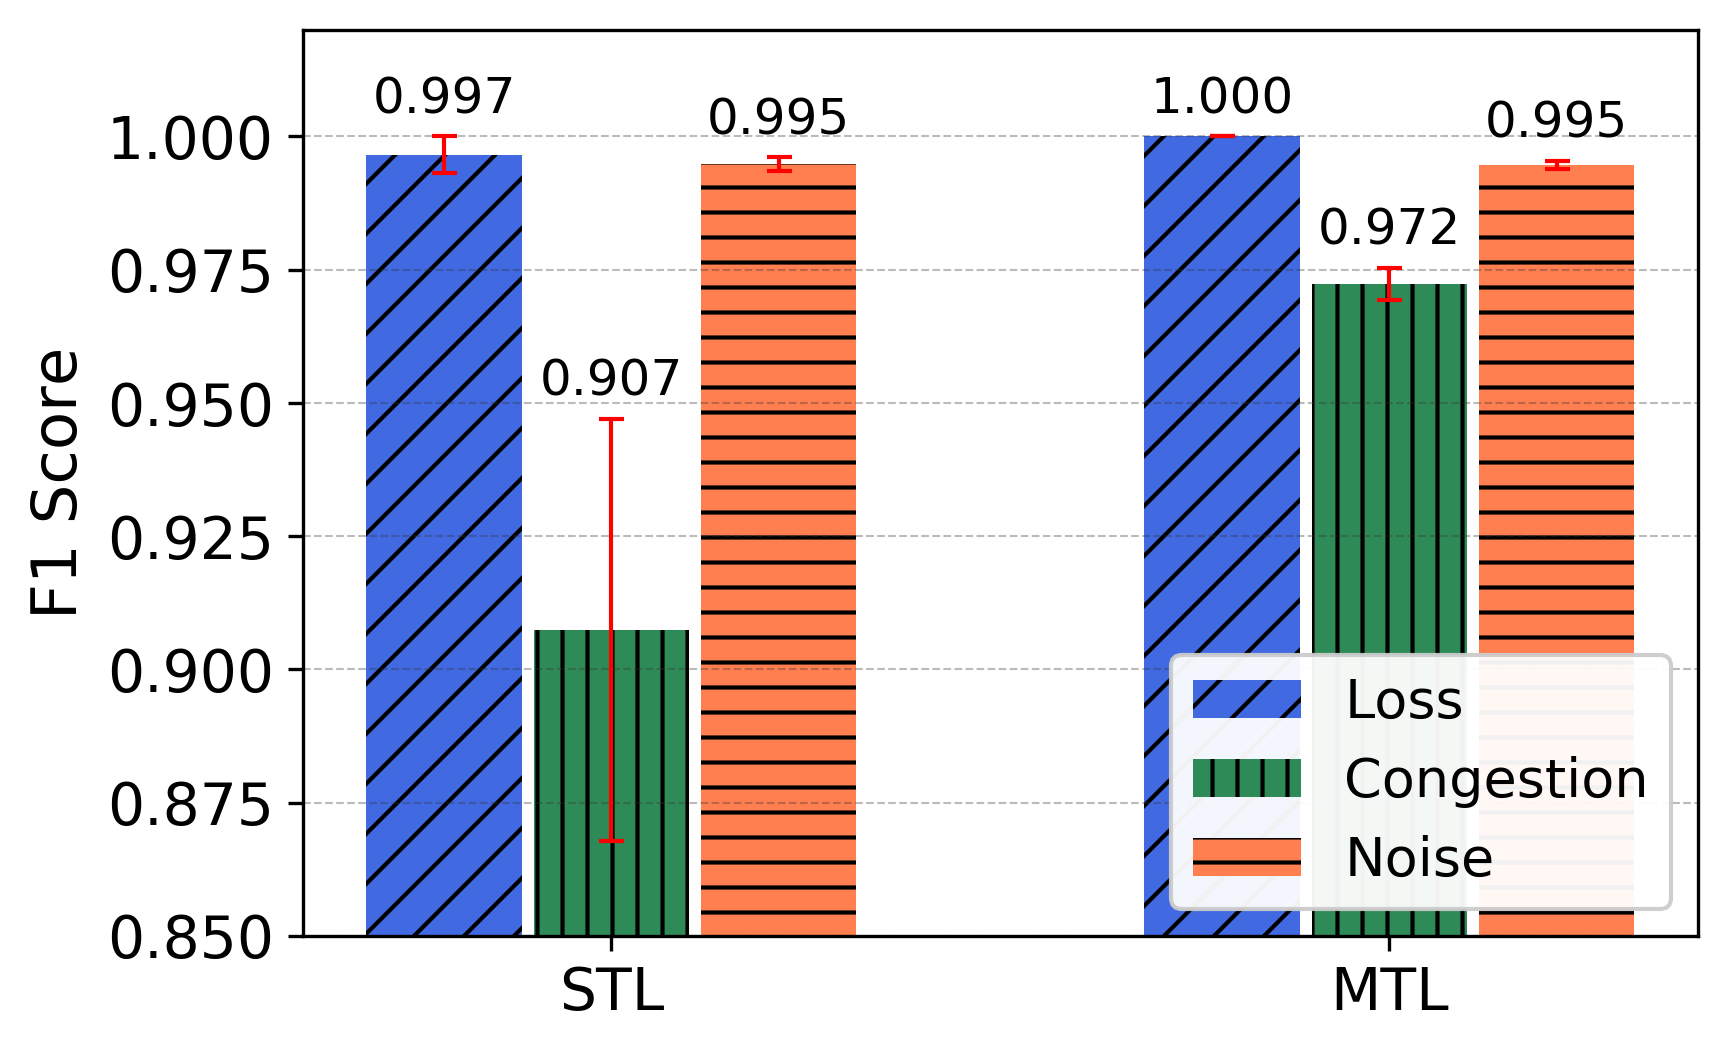

In [7]:
numGroups = 2

stl_means, mtl_means = [], []
stl_stdevs, mtl_stdevs = [], []
stl_stderr, mtl_stderr = [], []
stl_times = []

stdevs, data, stderrs = [], [], []

rects = {}

FONTSIZE = 14

for t in tasks:
    try:
        data.append([stl[f'{t}_mean_score'], mtl[f'{t}_mean_score']])
        stdevs.append([stl[f'{t}_stdev'], mtl[f'{t}_stdev']])
        stderrs.append([stl[f'{t}_stderr'], mtl[f'{t}_stderr']])
    except:
        data.append([0, mtl[f'{t}_mean_score']])
        stdevs.append([0, mtl[f'{t}_stdev']])
        stderrs.append([0, mtl[f'{t}_stderr']])

stl_devs = [i[0] for i in stdevs]
mtl_devs = [i[1] for i in stdevs]

ind = np.arange(numGroups) # x locations for the groups


margin = 0.015 # space between the bars
# margin = 0.018

# fig = plt.figure()
# print(plt.rcParams.get('figure.figsize'))
fig = plt.figure(figsize=(6, 4)) # default (base)
# fig = plt.figure(figsize=(7, 4)) # changepoint
# fig = plt.figure(figsize=(8, 4)) # good for all queries

ax = fig.add_subplot(111)


width = 0.18 # for queries
width = 0.2 # for changepoint
# width = 0.26 # for baseline


for i in range(len(data)):
    showError = True
    if showError:
        thickness = 1
        rects[i] = ax.bar(ind + (width * i) + (margin * i), data[i], width, color=colors[i], yerr=stderrs[i], hatch=hatches[i], \
                         error_kw=dict(ecolor='red', lw=thickness, capsize=3, capthick=thickness))
    else:
        rects[i] = ax.bar(ind + (width * i) + (margin * i), data[i], width, color=colors[i], hatch=hatches[i])

        
        
fntsize = 13    
LOC = "lower right"
# LOC = "upper left"
    
if 'query1' in tasks:
    ax.legend( (rects[0], rects[1], rects[2], rects[3], rects[4], rects[5]), ('Loss', 'Congestion', 'Noise', 'Changepoint', 'Task 1', 'Task 2'), \
              loc=LOC, framealpha=0.95, fontsize=fntsize)
else:
    if 'changepoint' in tasks:
        ax.legend( (rects[0], rects[1], rects[2], rects[3]), ('Loss', 'Congestion', 'Noise', 'Changepoint'), \
                  loc=LOC, framealpha=0.95, fontsize=fntsize)
    else:
        ax.legend( (rects[0], rects[1], rects[2]), ('Loss', 'Congestion', 'Noise'), \
                  loc=LOC, framealpha=0.95, fontsize=fntsize )


ax.set_ylabel('F1 Score', fontsize=FONTSIZE + 1)

if 'query1' in tasks:
    ax.set_xticks(ind + (width * ((len(tasks) - 1) / 2)) + margin)
#     ax.set_xticks([ind + 2 * width, 4 * width + margin + 3 * width + ind])
else:
    ax.set_xticks(ind + (width * ((len(tasks) - 1) / 2)) + margin)
ax.set_xticks(ind + (width * ((len(tasks) - 1) / 2)) + margin)
ax.set_xticklabels( ('STL', 'MTL'))
plt.grid(color='#333333', linestyle='--', linewidth=0.5, axis='y', alpha=0.33)
fig.set_dpi(300)

ax.tick_params(axis='both', labelsize=FONTSIZE)
# SMALL_SIZE = 8
# plt.rc('xtick', labelsize=SMALL_SIZE)
# plt.rc('ytick', labelsize=SMALL_SIZE)

# LB, UB = (0.9, 1.01) # normal
LB, UB = (0.85, 1.02) # optimal CAIDA base
# LB, UB = (0.475, 1.05) # optimal RIPE
# LB, UB = (0.395, 1.05)

def autolabel(rects, index):
    """
    Attach a text label above each bar displaying its height
    """
    for i in range(len(rects)):
        rect = rects[i]
        height = rect.get_height()
        
        myError = stderrs[index][i]
        
        margin = 0.005
        margin = 0.0025
        
        if height >= LB:
            ax.text(rect.get_x() + rect.get_width() / 2.0, height + myError + margin,
                    f'{round(height, 3):.3f}',
                    ha='center', va='bottom', fontsize=12)

[autolabel(rects[i], i) for i in range(len(tasks))] # use this to add the numerical score above each bar

ax.set_ylim([LB, UB]) # lower, upper bounds of the y-axis
# plt.savefig(fig_dir + "/synth_original.png", bbox_inches="tight")

plt.show()

In [8]:
speedUp = 0
scoreUps = []

for i in tasks:
    if 'query' in i:
        continue
    task = i
    scoreUp = mtl[f"{task}_mean_score"] - stl[f"{task}_mean_score"]
    speedUp += stl[f"{task}_mean_times"]
    
#     print(f"{i} Speedup: {round(speedUp, 3)} seconds ({round((1 - mean(mtl_times)/stl[f'{task}_mean_times']) * 100, 3)} %)")
    print(f"{i} Score Up: {round((mtl[f'{task}_mean_score']/stl[f'{task}_mean_score']) * 100 - 100, 3)}%")
    
#     speedUps.append(round((1 - mean(mtl_times)/stl[f'{task}_mean_times']) * 100, 3))
    scoreUps.append(round((mtl[f'{task}_mean_score']/stl[f'{task}_mean_score']) * 100 - 100, 3))
    print()
    
print(f"Average score improvements in MTL: {round(mean(scoreUps), 3)}%")
# print(f"{i} Speedup: {round(speedUp, 3)} seconds ({round((1 - mean(mtl_times)/stl[f'{task}_mean_times']) * 100, 3)} %)")
print(f"Average speed improvements in MTL: {round(speedUp / len(tasks), 3)}%")

# Comparing Results:
stl_time = 124.97112 + 48.80691 + 69.39006
mtl_time = 35.862854

stl_dev = math.sqrt(195.8448 + 77.45196 + 121.45299 / 3)
mtl_dev = 5.678691

percent_gain = 1 - (mtl_dev / stl_dev)
print(f"\nMTL is {round(percent_gain * 100, 3)}% less varied than STL.")

# percent_gain = 1 - (mtl_time / stl_time)
# print(f"MTL is {round(percent_gain * 100, 3)}% faster than STL.")

loss Score Up: 94.542%

congestion Score Up: 72.202%

noise Score Up: 57.151%

changepoint Score Up: 30.669%

Average score improvements in MTL: 63.641%
Average speed improvements in MTL: 200.421%

MTL is 67.942% less varied than STL.


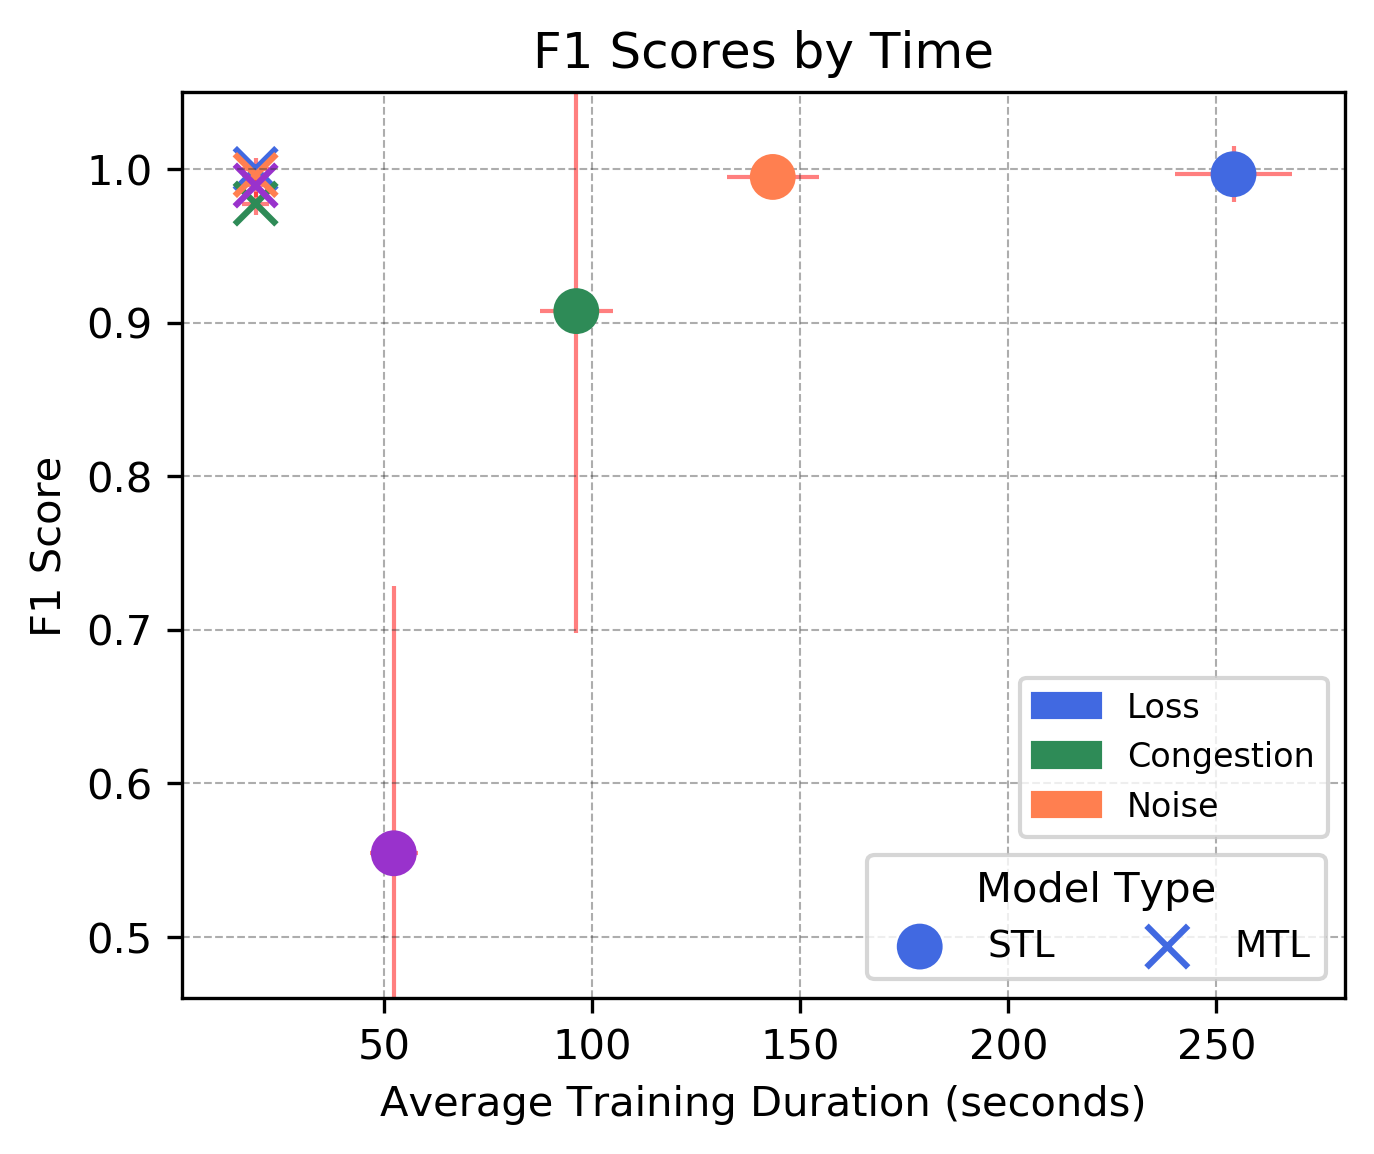

In [40]:
x1, x2 = [], [] # list of x-values (times)
y1, y2 = [], [] # list of y-values (F1 scores)
mtl_score_errs, stl_time_errs, stl_score_errs = [], [], []

for t in tasks:
    y1.append(stl[f'{t}_mean_score'])
    y2.append(mtl[f'{t}_mean_score'])
    
    x1.append(stl[f'{t}_mean_times'])
    x2.append(mean(mtl_times))
    
#     try:
    stl_time_errs.append(stl[t]['time_stdev'])
    stl_score_errs.append(stl[f'{t}_stdev'])
#     except:
#         stl_time_errs.append(0)
#         stl_score_errs.append(0)
    mtl_score_errs.append(mtl[f'{task}_stdev'])
    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.set_xlabel('Average Training Duration (seconds)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Time')


drawXerror, drawYerror = (True, True)
z = 0
a = 0.5

if drawXerror and drawYerror:
    ax.errorbar(x1, y1, xerr=stl_time_errs, yerr=stl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, xerr=mtl['time_stdev'], yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
elif drawXerror:
    ax.errorbar(x1, y1, xerr=stl_time_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, xerr=mtl['time_stdev'], fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
elif drawYerror:
    ax.errorbar(x1, y1, yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)
    ax.errorbar(x2, y2, yerr=mtl_score_errs, fmt='o', ecolor='red', \
                color='None', alpha=a, elinewidth=1, zorder=z)

    
scatter = ax.scatter(x1, y1, c=colors[:len(tasks)], marker="o", s=100, zorder=10)
scatter2 = ax.scatter(x2, y2, c=colors[:len(tasks)], marker="x", s=100)



# ax.set_ylim(0.9, 1.005) # lower, upper bounds of the y-axis
# ax.set_ylim(0.895, 1.005) # CAIDA bounds



if "ddos" in tasks:
    ax.set_ylim(0.45, 1.05) # RIPE 2
    legend1 = ax.legend(["STL", "MTL"], loc="lower left", ncol=2, title="Model Type", \
                    prop={'size': 9}) # LHS
    ax.add_artist(legend1)
    labels = ['Loss', 'Congestion', 'Noise', 'Changepoint', 'DDoS']
    
    handles = [mpatches.Patch(color=colors[labels.index(l)], label=l, ls="-") for l in labels]
    legend2 = ax.legend(handles, labels, loc="lower left", ncol=1, prop={'size': 8}, bbox_to_anchor=(0, .15)) # LHS
else:
    ax.set_ylim(0.46, 1.05) # RIPE
    legend1 = ax.legend(["STL", "MTL"], loc="lower right", ncol=2, title="Model Type", \
                        bbox_to_anchor=(1.0, 0.00), prop={'size': 9})
    ax.add_artist(legend1)
    labels = ['Loss', 'Congestion', 'Noise']
    
    handles = [mpatches.Patch(color=colors[labels.index(l)], label=l, ls="-") for l in labels]
    legend2 = ax.legend(handles, labels, loc="lower right", ncol=1, prop={'size': 8}, bbox_to_anchor=(1.0, 0.16)) # RHS


fig.set_dpi(300)
plt.grid(color='#333333', linestyle='--', linewidth=0.5, axis='both', alpha=0.4)

plt.show()